<div align="center">
  <h1></h1>
  <h1>Universidad Nacional de Colombia</h1>
  <h2>Desarrollo de un Modelo Predictivo para la clasificación de tipos celulares en piel a partir de Perfiles Transcriptómicos de scRNA-seq</h2>
  <strong>Trabajo Desarrollado por:</strong>  <br>
  Diego Andres Benitez Duarte (<a href="mailto:dabenitezd@unal.edu.co">dabenitezd@unal.edu.co</a>) <br>
  Jeraldine Muñoz Alvarado (<a href="mailto:jemunozal@unal.edu.co">jemunozal@unal.edu.co</a>) <br>
  Jhojan Sebastian Arango Castillo (<a href="mailto:jsarangoca@unal.edu.co">jsarangoca@unal.edu.co</a>) <br>
</div>

Link de acceso a los documentos relevantes:

# (1) Librerías

In [ ]:
!pip install xgboost lightgbm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import mode

from sklearn.decomposition import PCA

# Preprocesamiento:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Validación
from sklearn.metrics import accuracy_score,  precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score

# Modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Redes
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, Model
from tensorflow.keras.layers import Layer, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# (2) Carga de datos

Cargamos los datos de los tres pacientes seleccionados, junto con sus etiquetas. Los pacientes se diferencian con el identificador P+i, iniciando con i=1

In [ ]:
data_p1 = pd.read_csv('/content/Datos_Transpuestos_GSM8458830.csv', index_col=0)
data_p2 = pd.read_csv('/content/Datos_Transpuestos_GSM8458832.csv', index_col=0)
data_p3 = pd.read_csv('/content/Datos_Transpuestos_GSM8458836.csv', index_col=0)

labels_p1 = pd.read_csv('/content/Datos_Anotados_GSM8458830.csv', index_col=0)
labels_p2 = pd.read_csv('/content/Datos_Anotados_GSM8458832.csv', index_col=0)
labels_p3 = pd.read_csv('/content/Datos_Anotados_GSM8458836.csv', index_col=0)

Realizamos la verificación de dimensiones

In [ ]:
data_p1.shape, data_p2.shape, data_p3.shape

((7495, 2000), (12200, 2000), (4714, 2000))

In [ ]:
labels_p1.shape, labels_p2.shape, labels_p3.shape

((7495, 6), (12200, 6), (4714, 6))

# (3) Preprocesamiento

Concatenamos los conjuntos de datos.

In [ ]:
# Unimos los datasets (ejes verticales = células, horizontales = genes)
X = pd.concat([data_p1, data_p2, data_p3], axis=0).fillna(0)

# 3. Unir etiquetas
y = pd.concat([labels_p1, labels_p2, labels_p3], axis=0).squeeze()

# 4. Asegurar que los índices coincidan entre X e y
#    (intersección por seguridad, por si algún archivo tiene más filas que otro)
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

In [ ]:
#Verificamos que los índices coincidan
assert all(X.index == y.index), "Los índices no coinciden"

In [ ]:
X.shape, y.shape

((24409, 3060), (24409, 6))

In [ ]:
X.head(3)

,SPRR2E,CDSN,FLG,CST6,C15orf48,HLA-DRA,HOPX,DCT,LOR,HLA-DQA1,...,ARHGEF10L,KLF5,EMX2OS,IRX2,TSPAN33,PTBP2,NR1I3,AC007262.2,SHISA3,CDS1
AAACCCAAGCAAACAT.1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGCACTGGA.1,0,0,0,0,0,0,15,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAACTGGTT.1,0,0,0,0,0,0,8,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y.head(3)

,orig.ident,nCount_RNA,nFeature_RNA,batch,cell_type,tipo_muestra
AAACCCAAGCAAACAT.1,sampleA,1345,274,SampleB,Chondrocytes,Chondrocytes-SampleB
AAACCCAAGCACTGGA.1,sampleA,1430,197,SampleB,Keratinocytes,Keratinocytes-SampleB
AAACCCACAACTGGTT.1,sampleA,4901,291,SampleB,Keratinocytes,Keratinocytes-SampleB


## (3.1) Eliminación de índices duplicados.
Esta duplicidad en los índices (células) puede deberse a errores propios en el dataset.

In [ ]:
# verificación de filas duplicadas
duplicadas = X.duplicated(keep=False)
len(duplicadas[duplicadas])

0

No se encuentran filas completamente idénticas (duplicadas). Se procede a revisar los índices (células)

In [ ]:
X.shape, y.shape

((24409, 3060), (24409, 6))

Se identifican los índices únicos

In [ ]:
X.index.nunique(), y.index.nunique()

(24354, 24354)

Se mantiene el primer registro y se eliminan las células replicadas (Son errores en el dataset).

In [ ]:
X = X[~X.index.duplicated(keep='first')]
y = y[~y.index.duplicated(keep='first')]

In [ ]:
X.shape, y.shape

((24354, 3060), (24354, 6))

## (3.2) Filtrado de clases con pocas células.

Dado que las etiquetas cargadas en la variable 'y' contienen información adicional, definimos nuevamente la variable pero sólo con la información del tipo de célula

In [ ]:
y = y['cell_type']

Verificamos la frecuencia de cada célula

In [ ]:
y.value_counts()

,count
cell_type,
Keratinocytes,12695
T_cells,4195
Tissue_stem_cells,1625
Chondrocytes,1224
Endothelial_cells,872
Smooth_muscle_cells,857
NK_cell,750
Fibroblasts,727
CMP,374


Filtramos el conteo de las etiquetas para aquellas que tengan al menos 750 células.

In [ ]:
cell_counts = y.value_counts()
valid_classes = cell_counts[cell_counts >= 750].index

Aplicamos la matriz booleana para seleccionar únicamente los X que pertenecen a las clases válidas

In [ ]:
X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

In [ ]:
y.value_counts()

,count
cell_type,
Keratinocytes,12695
T_cells,4195
Tissue_stem_cells,1625
Chondrocytes,1224
Endothelial_cells,872
Smooth_muscle_cells,857
NK_cell,750


## (3.3) Balanceo de clases
Dado que el Dataset presenta un fuerte desbalanceo de clases, aplicaremos undersampling a las clases mayoritarias para balancear los datos con relación al tamaño de la célula que posee menos registros. En este caso, los NK_cell

In [ ]:
# Submuestreo para balancear clases
df_bal = X.copy()
df_bal['label'] = y

# Tamaño objetivo = tamaño de la clase más pequeña
min_count = df_bal['label'].value_counts().min()

# Submuestreo
df_balanced = pd.concat([
    resample(group, n_samples=min_count, random_state=42, replace=False)
    for _, group in df_bal.groupby('label')
])

# Separar nuevamente en X e y
X = df_balanced.drop(columns='label')
y = df_balanced['label']

In [ ]:
y.value_counts()

,count
label,
Chondrocytes,750
Endothelial_cells,750
Keratinocytes,750
NK_cell,750
Smooth_muscle_cells,750
T_cells,750
Tissue_stem_cells,750


## (3.3) Filtrado de genes con poca frecuencia de aparición.

Contamos en cuántas células se expresa cada gen

In [ ]:
n_cells_per_gene = (X>0).sum(axis=0)
n_cells_per_gene

,0
SPRR2E,174
CDSN,101
FLG,288
CST6,213
C15orf48,196
...,...
PTBP2,327
NR1I3,8
AC007262.2,9
SHISA3,8


Filtramos los genes que aparecen en pocas células

In [ ]:
X.shape[1]

3060

In [ ]:
total_genes = X.shape[1]
k_cel = 3

# Calcular cuántos genes se expresan en al menos K células
n_cells_per_gene = (X > 0).sum(axis=0)
genes_conservados = (n_cells_per_gene >= k_cel).sum()

# Calcular cuántos genes se eliminan
genes_eliminados = total_genes - genes_conservados

print(f"Genes totales antes del filtrado: {total_genes}")
print(f"Genes conservados (expresados en al menos {k_cel} células): {genes_conservados}")
print(f"Genes eliminados: {genes_eliminados}")

Genes totales antes del filtrado: 3060
Genes conservados (expresados en al menos 3 células): 2620
Genes eliminados: 440


In [ ]:
X_gen_bal = X.copy()

In [ ]:
X_gen_bal = X.loc[:, n_cells_per_gene >= k_cel]

##(3.4) CPM

Aplicamos CPM (Counts Per Million) para normalizar las cuentas de cada célula según su profundidad de secuenciación total, de esta manera, todas las células quedan comparables como si estuvieran en un millón de lecturas y se corrige el sesgo técnico

In [ ]:
X_cpm = X_gen_bal.div(X_gen_bal.sum(axis=1), axis=0) * 1e6

Normalizamos los resultados obtenidos de CPM con la transformación logarítmica

In [ ]:
X_log = np.log1p(X_cpm)

## (3.5) Selección del top mejores genes.



Utilizamos la función SelectKBest de la librería de ScikitLearn, la cual permite seleccionar las características más relevantes para predecir una variable objetivo, que en este caso, es el tipo de célula. Además, se utiliza el método f_classif el cual implementa el test ANOVA para cada gen individual y evalúa si la expresión del gen varía significativamente entre clases. Dependiendo del valor de F de la ANOVA, determina si el gen es discriminativo.

Las fórmulas utilizadas en `SelectKBest(score_func=f_classif, k=500)` son:

1. Media global del feature $x_j$:
$$
\bar{x}_j = \frac{1}{n} \sum_{i=1}^{n} x_{ij}
$$

2. Media por clase $c$, para la característica $x_j$:

$$
\bar{x}_{jc} = \frac{1}{n_c} \sum_{i \in G_c} x_{ij}
$$

Donde:
- $G_c$ es el conjunto de muestras pertenecientes a la clase $c$
- $n_c$ es el número de muestras en la clase $c$

3. Suma de cuadrados entre clases (SSB):

$$
SSB_j = \sum_{c=1}^{C} n_c \cdot (\bar{x}_{jc} - \bar{x}_j)^2
$$
4. Suma de cuadrados dentro de clases (SSW):

$$
SSW_j = \sum_{c=1}^{C} \sum_{i \in G_c} (x_{ij} - \bar{x}_{jc})^2
$$
5. Grados de libertad:

- Entre clases: $df_{\text{entre}} = C - 1$
- Dentro de clases: $df_{\text{dentro}} = n - C$

6. Estadístico F (F-statistic) para la característica $x_j$:

$$
F_j = \frac{SSB_j / (C - 1)}{SSW_j / (n - C)}
$$

Valores altos de $F_j$ indican que la variable $x_j$ tiene mucha variabilidad entre clases y poca dentro de las clases, lo que la convierte en una buena candidata para clasificación.

In [ ]:
selector = SelectKBest(score_func=f_classif, k=500)
X_selected = selector.fit_transform(X_log, y)

##(3.6) Estandarización

Dado que los datos de single cell vienen en un conteo muy disperso entre genes, se recomienda escalar los datos antes de entrenar los modelos. Por tanto aplicamos StandardScaler para que cada gen tenga una expresión con media 0 y desviación estándar 1. La fórmula que se implementa es:
$$
z = \frac{x - \mu}{\sigma}
$$

Donde:

- $x$ es el valor original  
- $\mu$ es la media de la característica  
- $\sigma$ es la desviación estándar

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

## (3.7) Mapeo de las etiquetas

Utilizamos la función LabelEncoder para convertir las etiquetas categóricas como 'T cell', 'NK_cell', etc. en números enteros 0, 1, ... para que puedan ser interpretados por los algoritmos de ML.

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

## (3.8) División del dataset

Realizamos la división del conjunto de datos en 80% entrenamiento y 20% validación

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y
)

#(4). Modelos

Dentro de la revisión de literatura se encontraron múltiples técnicas de Machine Learning para la anotación de células en secuencias scRNA. Dentro de estas técnicas se encontraron:  Árboles de decisión, Random Forest, Gradient Boosting, K-nearest-neighbour, Support Vector Machines, etc. (Wani, S. et al, 2025). Por tal motivo, utilizaremos algunos de estos algoritmos y sus variaciones para tener un punto de comparación con los resultados obtenidos por medio de una red neuronal sencilla, la red scCapsNet (Wang, el al. 2022) y la red GRU (Zhou, et al. 2022) que fueron encontradas en la revisión literatura.

##(4.1) Random Forest

Una técnica de ensamble utilizada para clasificar tipos de células en datos de scRNA-seq. En principio, el RF construye múltiples árboles de decisión utilizando subconjuntos aleatorios de datos y características (bagging). Cada árbol predice un tipo de célula, y el resultado final se basa en el voto mayoritario (Majid, M. et al 2023, citado por Wani, S. et al, 2025)

In [ ]:
class_names = le.classes_ # Esto lo utilizaremos posteriormente para construir las matrices de confusión con las etiquetas

In [ ]:
# Entrenamiento del random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

Random Forest:
Accuracy: 0.8314

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       150
           1       0.99      1.00      1.00       150
           2       1.00      1.00      1.00       150
           3       0.91      0.83      0.86       150
           4       0.68      0.57      0.62       150
           5       0.84      0.92      0.88       150
           6       0.74      0.77      0.75       150

    accuracy                           0.83      1050
   macro avg       0.83      0.83      0.83      1050
weighted avg       0.83      0.83      0.83      1050



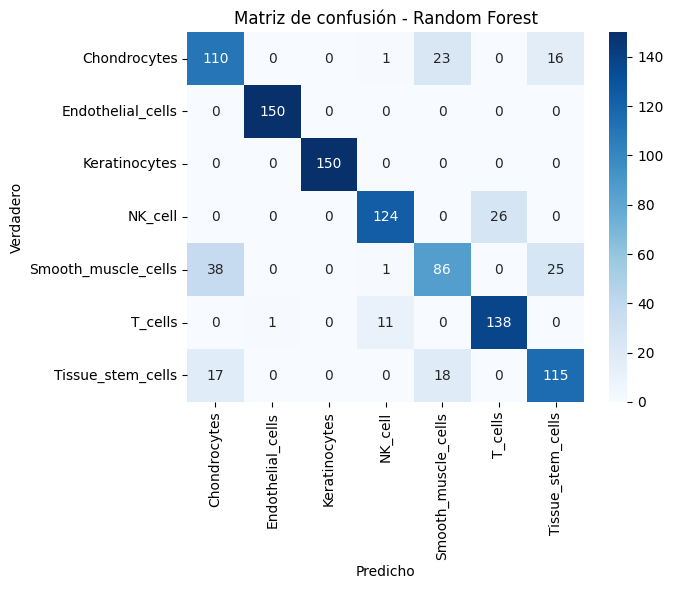

In [ ]:
# Evaluación del modelo
y_pred_rf = rf.predict(X_test)

print("Random Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusión - Random Forest')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

## (4.2) Regresión logística

Es un método de aprendizaje automático utilizado para clasificar tipos de células en datos de scRNA-seq, valorado por su simplicidad, interpretabilidad y salida probabilística (Hosmer, D.W. 2013). Su objetivo es modelar la probabilidad de que una célula dada pertenezca a un tipo de célula específico basándose en su perfil de expresión génica. Además, extiende a la regresión logística multinomial para clasificar múltiples tipos de células simultáneamente. Para esto, calcula una suma ponderada de los valores de expresión génica, donde los pesos indican la contribución de cada gen a la decisión de clasificación (Wani, S. et al, 2025).

En este caso se utiliza la función LogisticRegression de Sklearn con penalización l2 para prevenir overfitting y se deja el solver por defecto 'lbfgs' que minimiza la pérdida multinomial. En este caso, se debe evitar usar el solver liblinear ya que no se trata de clasificación binaria sino multiclase.

In [ ]:
# Entrenamiento de la regresión logística con penalización l2
lr = LogisticRegression(max_iter=1000, C=1.0, penalty='l2')
lr.fit(X_train, y_train)

Regresión Logística
Accuracy: 0.8219
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       150
           1       0.99      0.99      0.99       150
           2       0.99      1.00      1.00       150
           3       0.92      0.91      0.92       150
           4       0.63      0.63      0.63       150
           5       0.91      0.91      0.91       150
           6       0.67      0.67      0.67       150

    accuracy                           0.82      1050
   macro avg       0.82      0.82      0.82      1050
weighted avg       0.82      0.82      0.82      1050



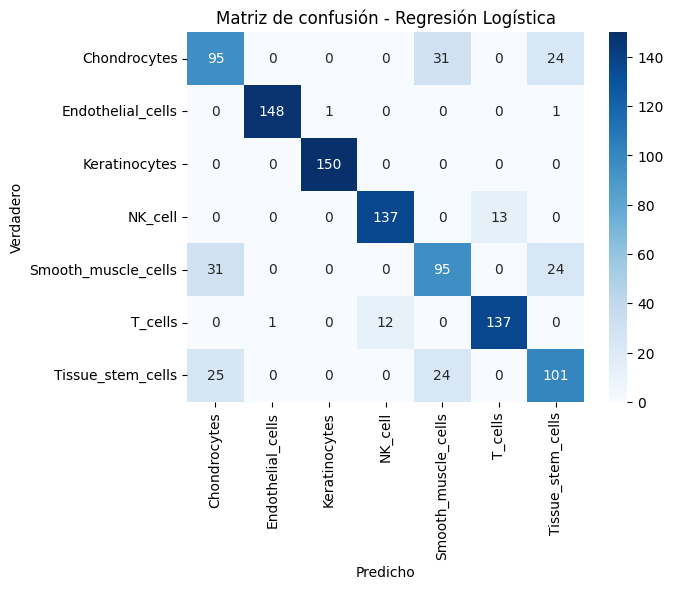

In [ ]:
# Evaluación del modelo
y_pred_lr = lr.predict(X_test)
print("Regresión Logística")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr, zero_division=0))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusión - Regresión Logística')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

## (4.3) Gradient Boosting

Un método de aprendizaje automático robusto utilizando para la clasificación de diferentes tipos de célula (Wani, S. et al, 2025). El método construye árboles secuencialmente, donde cada árbol corrige los errores de los anteriores mediante un método llamado "boosting", minimizando una función de pérdida a través del descenso de gradiente (Natekin, A. et al 2023, citado por Wani, S. et al, 2025)

In [ ]:
# Entrenamiento del Gradient Boosting con parámetros estándar.
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
gb.fit(X_train, y_train)

GradientBoostingClassifier()

Gradient Boosting
Accuracy: 0.8514
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       150
           1       0.99      0.99      0.99       150
           2       1.00      0.99      0.99       150
           3       0.90      0.85      0.88       150
           4       0.74      0.67      0.70       150
           5       0.86      0.92      0.89       150
           6       0.75      0.75      0.75       150

    accuracy                           0.85      1050
   macro avg       0.85      0.85      0.85      1050
weighted avg       0.85      0.85      0.85      1050



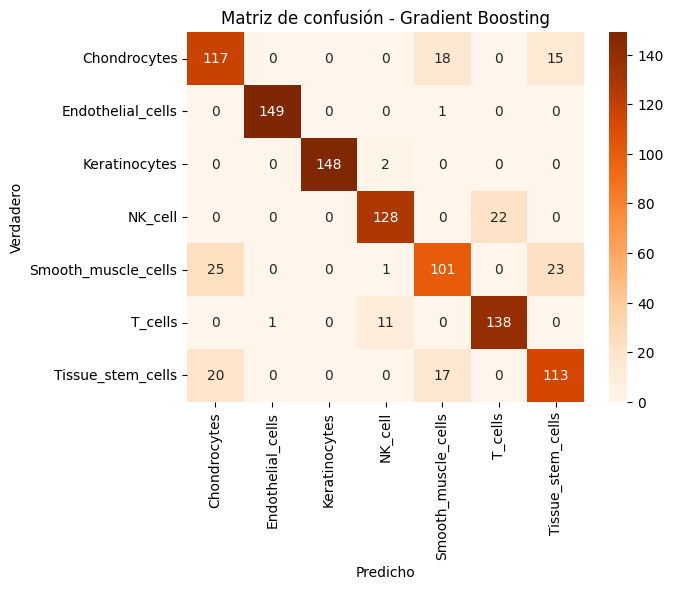

In [ ]:
# Evaluación del modelo
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(classification_report(y_test, y_pred_gb, zero_division=0))

cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusión - Gradient Boosting')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

Adicionalmente, incluimos algunas variaciones del método de Gradient Boosting como el AdaBoost, XGBoost y el LightGBM

## (4.4) AdaBoost

AdaBoost, abreviado de Adaptive Boosting, es un algoritmo de aprendizaje automático de ensamble que puede utilizarse en una amplia variedad de tareas de clasificación y regresión. Es un algoritmo de aprendizaje supervisado que clasifica los datos combinando múltiples modelos débiles o básicos (por ejemplo, árboles de decisión) en un modelo fuerte (Tarun, D. 2025). AdaBoost funciona asignando más peso a los "aprendices débiles" (modelos cuya precisión es ligeramente mejor que el azar) y menos peso a los "aprendices fuertes". (Ramraj, et al., 2016)

In [ ]:
# Entrenamiento del AdaBoost
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

AdaBoost
Accuracy: 0.7086
              precision    recall  f1-score   support

           0       0.56      0.37      0.44       150
           1       0.99      0.97      0.98       150
           2       1.00      0.96      0.98       150
           3       0.74      0.67      0.71       150
           4       0.41      0.64      0.50       150
           5       0.71      0.80      0.75       150
           6       0.68      0.55      0.61       150

    accuracy                           0.71      1050
   macro avg       0.73      0.71      0.71      1050
weighted avg       0.73      0.71      0.71      1050



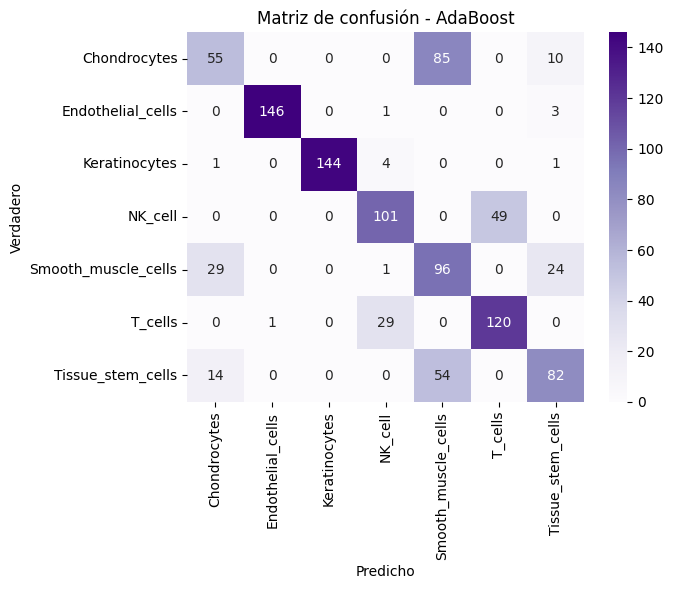

In [ ]:
# Evaluación del modelo
print("AdaBoost")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ada):.4f}")
print(classification_report(y_test, y_pred_ada, zero_division=0))

cm_ada = confusion_matrix(y_test, y_pred_ada)
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusión - AdaBoost')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

## (4.5) XGBoost

XGBoost (Extreme Gradient Boosting) es una implementación altamente eficiente y escalable del algoritmo de Gradient Boosting. A diferencia del gradient boosting simple, donde los "aprendices débiles" se añaden uno tras otro, XGBoost utiliza un enfoque multi-hilo. Esto aprovecha múltiples núcleos de CPU de la máquina, lo que se traduce en una mayor velocidad y rendimiento (Ramraj, et al., 2016).


In [ ]:
# Entrenamiento del XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric="logloss")
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

XGBoost
Accuracy: 0.8457
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       150
           1       1.00      0.99      1.00       150
           2       0.99      0.99      0.99       150
           3       0.91      0.86      0.89       150
           4       0.72      0.67      0.69       150
           5       0.87      0.93      0.90       150
           6       0.74      0.73      0.74       150

    accuracy                           0.85      1050
   macro avg       0.85      0.85      0.85      1050
weighted avg       0.85      0.85      0.85      1050



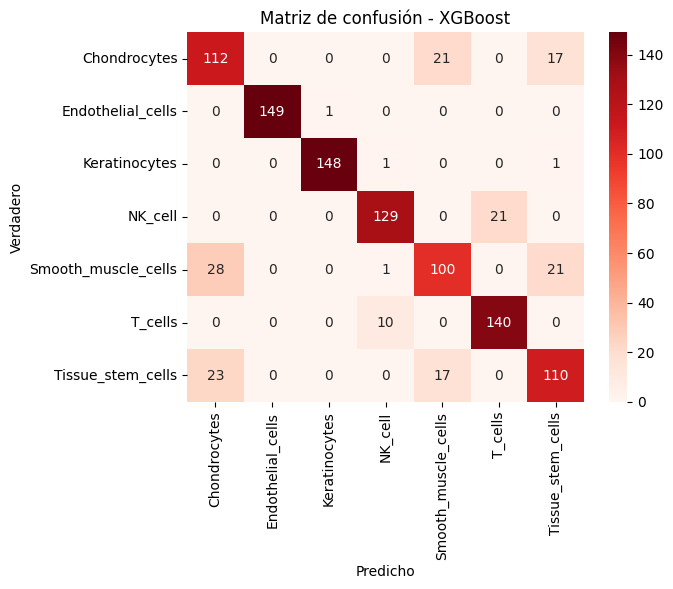

In [ ]:
# Evaluación del modelo
print("XGBoost")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(classification_report(y_test, y_pred_xgb, zero_division=0))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusión - XGBoost')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

## (4.6) LightGBM

LightGBM, al igual que el XGBoost, es una implementación altamente eficiente del algoritmo de árboles de decisión de gradient boosting (Lyu, J. 2023). A diferencia de otros métodos de boosting que construyen árboles secuencialmente, LightGBM incorpora optimizaciones clave para mejorar la velocidad y la eficiencia sin sacrificar la precisión predictiva (Lyu, J. 2023).

In [ ]:
# Entrenamiento del LightGBM
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.1)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100798
[LightGBM] [Info] Number of data points in the train set: 4200, number of used features: 500
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM
Accuracy: 0.8448
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       150
           1       0.99      0.99      0.99       150
           2       0.99      0.99      0.99       150
           3       0.91      0.85      0.88       150
           4       0.74      0.66      0.70       150
           5       0.86      0.93      0.89       150
           6       0.74      0.73      0.73       150

    accuracy                           0.84      1050
   macro avg       0.85      0.84      0.84      1050
weighted avg       0.85      0.84      0.84      1050



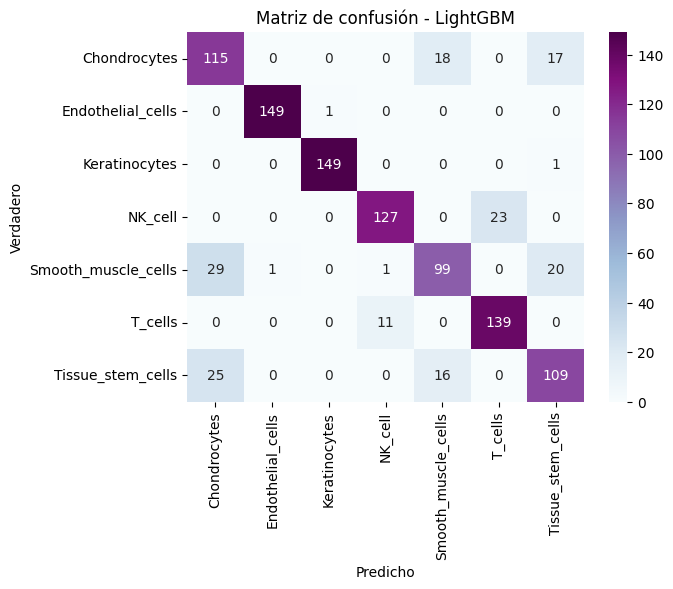

In [ ]:
# Evaluación del modelo
print("LightGBM")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print(classification_report(y_test, y_pred_lgbm, zero_division=0))

cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='BuPu',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusión - LightGBM')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

## (4.7) Support Vector Machine

Según la literatura, el método SVM es ampliamente utilizado para la clasificación de tipos de células en datos de scRNA-seq debido a su capacidad para manejar datos de alta dimensión y complejos (Wani, S. et al, 2025).

 Su principio central es encontrar un hiperplano óptimo que separe diferentes tipos de células en el espacio de expresión génica con el margen máximo, minimizando la clasificación errónea (Cao, X., et al. 2022, citado por Wani, S. et al, 2025) Cuando los tipos de células no son linealmente separables, SVM utiliza funciones de kernel (como la función de base radial o RBF) para transformar los datos a un espacio de mayor dimensión donde se pueda identificar un hiperplano de separación (Saygili, G. 2023, citado por Wani, S. et al, 2025).

In [ ]:
# Entrenamiento del modelo SVM
svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

Support Vector Machine
Accuracy: 0.8533
              precision    recall  f1-score   support

           0       0.69      0.79      0.73       150
           1       0.99      1.00      1.00       150
           2       1.00      1.00      1.00       150
           3       0.90      0.91      0.91       150
           4       0.74      0.61      0.67       150
           5       0.91      0.89      0.90       150
           6       0.75      0.77      0.76       150

    accuracy                           0.85      1050
   macro avg       0.85      0.85      0.85      1050
weighted avg       0.85      0.85      0.85      1050



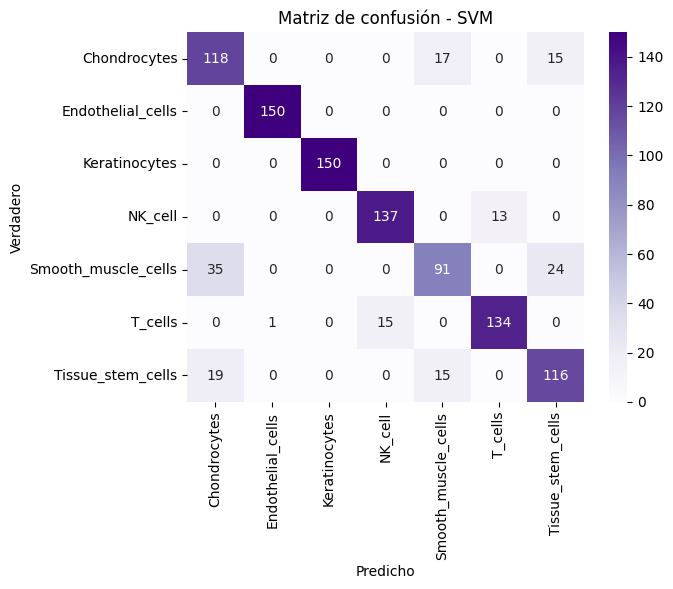

In [ ]:
# Evaluación del modelo
print("Support Vector Machine")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(classification_report(y_test, y_pred_svm, zero_division=0))

cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusión - SVM')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

## (4.8) K-nearest neighbour

Es un algoritmo simple, no paramétrico y basado en la distancia, utilizado en datos de scRNA-seq para la clasificación de tipos de células (Dann, E. 2021,citado por Wani, S. et al, 2025). Este algoritmo
asume que las células similares están cerca en el espacio de expresión génica. Para una célula dada, KNN encuentra sus k vecinos más cercanos utilizando una métrica de distancia y asigna la etiqueta más común entre ellos (Stuart, T. et al 2019, citado por por Wani, S. et al, 2025)

In [ ]:
# Entrenamiento del modelo KNN
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

K-Nearest Neighbors (KNN)
Accuracy: 0.8076
              precision    recall  f1-score   support

           0       0.66      0.69      0.67       150
           1       0.99      0.97      0.98       150
           2       1.00      0.97      0.98       150
           3       0.79      0.87      0.83       150
           4       0.70      0.57      0.63       150
           5       0.87      0.87      0.87       150
           6       0.65      0.72      0.68       150

    accuracy                           0.81      1050
   macro avg       0.81      0.81      0.81      1050
weighted avg       0.81      0.81      0.81      1050



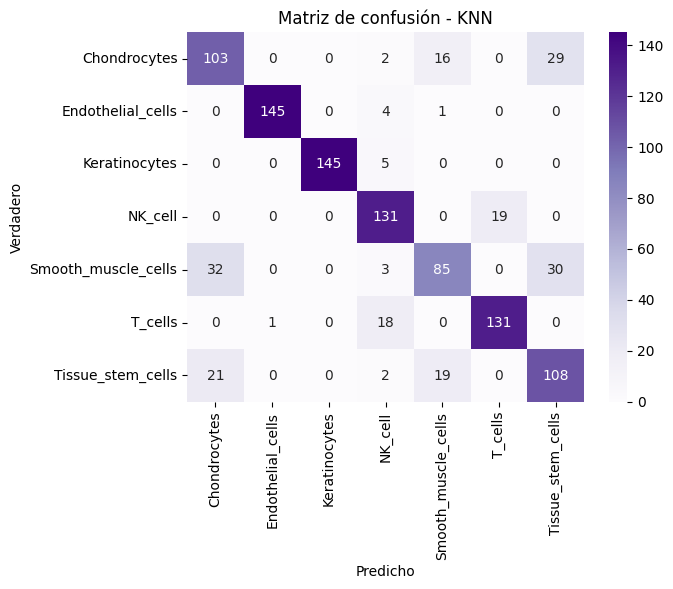

In [ ]:
# Evaluación del modelo
print("K-Nearest Neighbors (KNN)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(classification_report(y_test, y_pred_knn, zero_division=0))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusión - KNN')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

# (5) Redes neuronales

## (5.1) Red neuronal profunda

Para iniciar, dado que los algoritmos de Machine Learning implementados arrojaban en general métricas aceptables, se plantea una red neuronal con un arquitectura simple para tener como punto de comparación con las redes neuronales encontradas en la literatura.  

La red a continuación es una red neuronal densa totalmente conectada para clasificación multiclase. Esta red neuronal consta de 4 capas densas con 128, 64, 32 y 16 neuronas con activación RELU, mediante las cuales se reduce sucesivamente la dimensionalidad y se extraen las representaciones de los genes progresivamente. Posterior a las 4 capas, se cuenta con una capa densa de salida, la cual tiene tantas neuronas como número de clases (7) y una función de activación Softmax que retorna un vector de probabilidades (una probabilidad por cada clase) y la predicción será la clase con mayor probabiidad.

Previo al entrenamiento de la red, se convierten las etiquetas categóricas (nombres de las células) en vector binarios para poder utilizar la función de pérdida categorical_crossentropy junto con la función softmax. Por otra parte, se implementan 1 capa de dropout tras cada capa densa (solo en las primeras tres capas) para evitar el sobreajuste de la red.

In [ ]:
num_classes = len(np.unique(y_train))

# Aplicamos one-hot encoding para las etiquetas Y dado que utilizaremos una softmax
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)


# Definimos la arquitectura de la red con activación softmax en la última capa densa.
nn = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
nn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 128)            │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,335 (880.22 KB)

 Trainable params: 75,111 (293.40 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 150,224 (586.82 KB)

En esta parte, se utiliza el optimizador adam y se define la función de pérdida 'categorical_crossentropy', dado que se trata de un problema de clasificación multiclase.

Además, se define como métrica de control la pérdida de validación y se define una paciencia de 5 épocas para parar el modelo en caso de que la función de pérdida de la validación no mejore con el entrenamiento.

In [ ]:
nn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy', # Utilizamos la función de pérdida "categorical_crossentropy" para la clasificación multiclase.
    metrics=['accuracy']
)


history = nn.fit(
    X_train, y_train_one_hot,
    validation_data=(X_test, y_test_one_hot),
    epochs=20,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True)
    ],
    verbose=1
)

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4067 - loss: 1.4973 - val_accuracy: 0.7381 - val_loss: 0.5675
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6905 - loss: 0.6599 - val_accuracy: 0.8086 - val_loss: 0.4380
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7726 - loss: 0.5452 - val_accuracy: 0.8295 - val_loss: 0.4195
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7970 - loss: 0.4839 - val_accuracy: 0.8343 - val_loss: 0.3875
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8126 - loss: 0.4327 - val_accuracy: 0.8571 - val_loss: 0.3676
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8378 - loss: 0.4014 - val_accuracy: 0.8476 - val_loss: 0.3551
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8436 - loss: 0.3834 - val_accuracy: 0.8524 - val_loss: 0.3562
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8509 - loss: 0.3598 - val_accuracy: 0.

Computamos nuevamente las predicciones de la red neuronal ya entrada para construir la matriz de confusión y el reporte de clasificación.

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Red neuronal
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       150
           1       0.99      1.00      1.00       150
           2       1.00      1.00      1.00       150
           3       0.91      0.89      0.90       150
           4       0.75      0.57      0.65       150
           5       0.90      0.91      0.90       150
           6       0.68      0.83      0.75       150

    accuracy                           0.85      1050
   macro avg       0.85      0.85      0.85      1050
weighted avg       0.85      0.85      0.85      1050



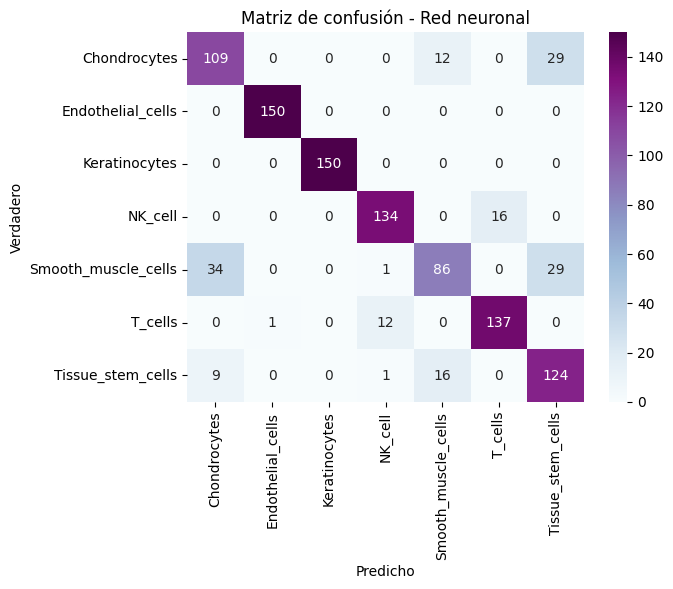

In [ ]:
y_pred_nn = nn.predict(X_test) # Realizamos la predicción
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1) # Seleccionamos la clase con mayor probabilidad

print("Red neuronal")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0))

cm_nn = confusion_matrix(y_test, y_pred_nn_classes)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='BuPu',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusión - Red neuronal')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

Se grafican los valores de precision global (accuracy) por época durante el entrenamiento y la validación, junto con los valores de la función de pérdida por época de estas mismas etapas. Estas gráficas, nos permiten identificar en qué momento del entrenamiento se comienza a presentar overfitting o underfitting. El análisis detallado de estos resultados se encuentra en el artículo.

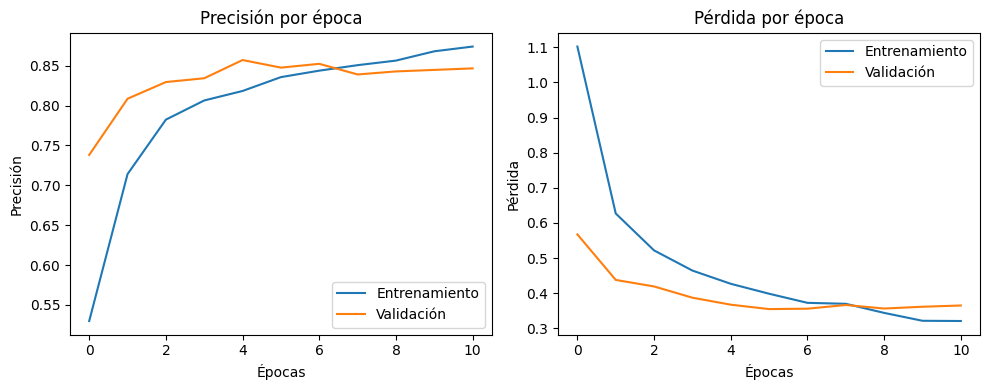

In [ ]:
# Accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

## (5.2) scCapsNet

Tomando como base la arquitectura de la red CapsuleNet planteada por Wang, L. et al. (2020). En la CapsuleNet se reemplaza las neuronas tradicionales por cápsulas que producen vectores. Estos vectores representan no solo la presencia de una entidad (por ejemplo, un tipo celular), sino también sus atributos, en este caso, patrones de expresión génica (Wang, L et al. 2020).

Respecto a los elementos que conforman la red:
* Función **squash**: es una función de activación especial para las cápsulas que "aplasta" los vectores para que su norma esté entre 0 y 1. De tal manera que cuando pasan vectores pequeños los valores se hacen cercanos a cero y en los vectores grandes, se acercan a 1. Esta función se utiliza para representar la presencia o ausencia de características en las células.

* Función **softmax**: los autores implementan una función softmax pero para una actividad diferente a la que realizamos con la anterior red neuronal. En este caso, la función softmax se utiliza para el enrutamiento dinámico, mediante el cual se calculan los coeficientes de acomplamiento que determinan cuanto contribuye cada capsula primaria a cada cápsula tipo.


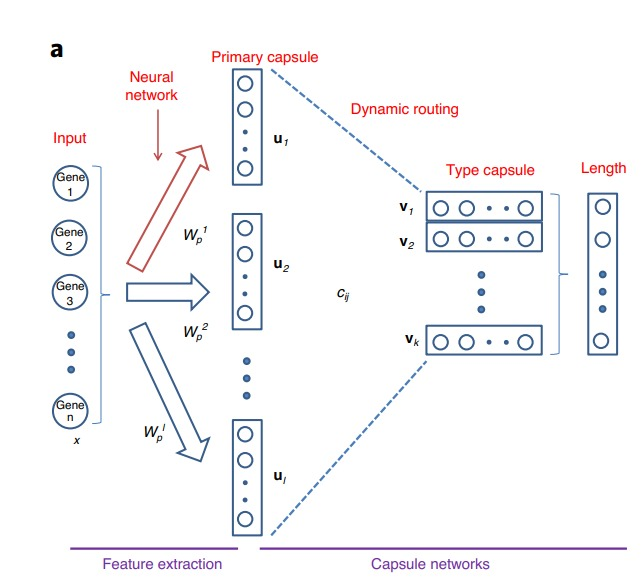

Continuando, respecto a la arquitectura de la red se tiene:
1. **Entrada:** Se ingresa un vector de expresión génica de una célula.
2. **Extracción de características:** Se usan múltiples redes neuronales totalmente conectadas en paralelo y cada red convierte la entrada en un vector, llamado cápsula primaria $u_i$. Cada cápsula captura una representación específica del perfil de expresión.
3. **Cápsulas primarias:** Son los vectores salientes de cada red en el bloque extractor que codifican distintas propiedades de las células. Esta información capturada debe ser útil para distinguir entre tipos celulares.
4. **Cápsulas tipo:** cada una representa un tipo celular (clases del dataset). Estas cápsulas reciben n información de todas las cápsulas primarias a través de un mecanismo llamado enrutamiento dinámico.
5. **Enrutamiento dinámico:** Es un algoritmo iterativo que aprende cuánto debe contribuir cada cápsula primaria $u_i$ a cada cápsula de tipo $v_k$.
6. Salida: La longitud del vector $v_j$ indica la probabilidad de que la célula pertenezca a ese tipo.

In [ ]:
# Función de activación squash: aplasta vectores para que su norma esté entre 0 y 1
def squash(x, axis=-1): # Es una función de activación especial para las cápsulas
    s_squared_norm = tf.reduce_sum(tf.square(x), axis, keepdims=True) + K.epsilon() # Magnitud al cuadrado + estabilidad numérica (epsilon)
    scale = tf.sqrt(s_squared_norm) / (0.5 + s_squared_norm) # Factor de escala
    return scale * x # Retorna el vector con magnitud "aplastada"

# Softmax personalizado para aplicar sobre un eje específico (se usa en el enrutamiento dinámico)
def softmax(x, axis=-1):
    ex = tf.exp(x - tf.reduce_max(x, axis=axis, keepdims=True))
    return ex / tf.reduce_sum(ex, axis=axis, keepdims=True)

class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule # número de cápsulas de salida (clases)
        self.dim_capsule = dim_capsule #tamaño del vector de cada cápsula de salida.
        self.routings = routings # número de iteraciones de enrutamiento dinámico
        self.share_weights = share_weights # En caso de que sea "True" todas las cápsulas compartirían la misma matriz de pesos.

        # Selección de función de activación
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = int(input_shape[-1]) # Dimensión de entrada por cápsula primaria

         # Pesos compartidos entre cápsulas primarias si share_weights=True
        if self.share_weights:
            self.W = self.add_weight(
                shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                name='capsule_kernel',
                trainable=True
            )
        # Pesos independientes para cada cápsula primaria si share_weights=False
        else:
            input_num_capsule = int(input_shape[-2])
            self.W = self.add_weight(
                shape=(input_num_capsule, input_dim_capsule, self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                name='capsule_kernel',
                trainable=True
            )
        super(Capsule, self).build(input_shape)

    def call(self, u_vecs):
       # Multiplicación de vectores de entrada con matriz de pesos para generar predicciones
        if self.share_weights:
            u_hat_vecs = tf.linalg.matmul(u_vecs, self.W)
        else:
            u_hat_vecs = tf.einsum('bij,ijk->bik', u_vecs, self.W)

        # Forma del lote y número de cápsulas de entrada
        batch_size = tf.shape(u_vecs)[0]
        input_num_capsule = tf.shape(u_vecs)[1]

        # Redimensionar y transponer para preparar enrutamiento
        u_hat_vecs = tf.reshape(u_hat_vecs, [batch_size, input_num_capsule, self.num_capsule, self.dim_capsule])
        u_hat_vecs = tf.transpose(u_hat_vecs, [0, 2, 1, 3])

        # Inicialización de logits b (coeficientes de acoplamiento sin normalizar)
        b = tf.zeros_like(u_hat_vecs[:, :, :, 0]) # [batch, num_capsules_out, num_capsules_in]

        for i in range(self.routings):
            c = softmax(b, axis=1)
            c_expanded = tf.expand_dims(c, -1)
            weighted_preds = c_expanded * u_hat_vecs
            o = tf.reduce_sum(weighted_preds, axis=2)
            if i < self.routings - 1:
                o = tf.nn.l2_normalize(o, axis=-1)
                o_expanded = tf.expand_dims(o, 2)
                b += tf.reduce_sum(u_hat_vecs * o_expanded, axis=-1)

        return self.activation(o)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_capsule, self.dim_capsule)

In [ ]:
z_dim = 16 # Dimension de las cápsulas, en la literatura recomiendan valores de 8, 16 y 32,
           # dependiendo del tamaño del conjunto de datos
           # Esta dimensión es la representación

input_size = X_train.shape[1]
x_in = Input(shape=(input_size,))

# Crear 20 capas Dense con la misma entrada
capsule_inputs = [Dense(z_dim, activation='relu')(x_in) for _ in range(20)]

# Concatenar y dar forma
x = Concatenate()(capsule_inputs)
x = Reshape((20, z_dim))(x)

# Capa de cápsulas
capsule = Capsule(num_capsule=num_classes, dim_capsule=20, routings=3, share_weights=False)(x)

# Longitud del vector como salida (como en el paper original)
output = Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x), axis=2)))(capsule)

CapsuleNetModel = Model(inputs=x_in, outputs=output)

# Se utiliza la función de pérdida personalizada por el autor.
CapsuleNetModel.compile(loss=lambda y_true,y_pred: y_true*tf.nn.relu(0.9-y_pred)**2 + 0.25*(1-y_true)*tf.nn.relu(y_pred-0.1)**2,
              optimizer='adam',
              metrics=['accuracy'])

CapsuleNetModel.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_87 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_88 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_89 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_90 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_91 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_94 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_95 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_96 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_97 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_98 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_99 (Dense)    │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_100 (Dense)   │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_101 (Dense)   │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_102 (Dense)   │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_103 (Dense)   │ (None, 16)        │      8,016 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 320)       │          0 │ dense_84[0][0],   │
│ (Concatenate)       │                   │            │ dense_85[0][0],   │
│                     │                   │            │ dense_86[0][0],   │
│                     │                   │            │ dense_87[0][0],   │
│                     │                   │            │ dense_88[0][0],   │
│                     │                   │            │ dense_89[0][0], 

 Total params: 205,120 (801.25 KB)

 Trainable params: 205,120 (801.25 KB)

 Non-trainable params: 0 (0.00 B)

Realizamos el entrenamiento del modelo, utilizando como referencia los parámetros del autor del artículo.

In [ ]:
Caps_History = CapsuleNetModel.fit(X_train, y_train_one_hot,
          batch_size=400,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test_one_hot))

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.5866 - loss: 0.0435 - val_accuracy: 0.7895 - val_loss: 0.0194
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7898 - loss: 0.0169 - val_accuracy: 0.8200 - val_loss: 0.0125
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8450 - loss: 0.0111 - val_accuracy: 0.8248 - val_loss: 0.0106
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8514 - loss: 0.0094 - val_accuracy: 0.8410 - val_loss: 0.0100
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8710 - loss: 0.0081 - val_accuracy: 0.8505 - val_loss: 0.0096
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8890 - loss: 0.0070 - val_accuracy: 0.8467 - val_loss: 0.0094
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8954 - loss: 0.0064 - val_accuracy: 0.8524 - val_loss: 0.0093
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9142 - loss: 0.0056 - val_accuracy: 0.8457 -

Generamos las curvas de accuracy y de la pérdida durante el entrenamiento y la validación

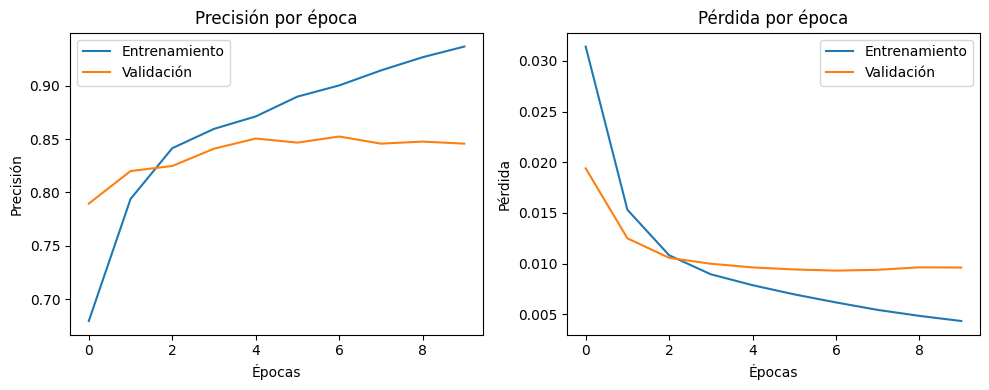

In [ ]:
# Accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(Caps_History.history['accuracy'], label='Entrenamiento')
plt.plot(Caps_History.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1,2,2)
plt.plot(Caps_History.history['loss'], label='Entrenamiento')
plt.plot(Caps_History.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

Calculamos las métricas del modelo entrenado

CapsuleNet
                     precision    recall  f1-score   support

       Chondrocytes       0.71      0.76      0.74       150
  Endothelial_cells       0.99      1.00      1.00       150
      Keratinocytes       0.99      0.99      0.99       150
            NK_cell       0.90      0.86      0.88       150
Smooth_muscle_cells       0.72      0.61      0.66       150
            T_cells       0.87      0.91      0.89       150
  Tissue_stem_cells       0.73      0.79      0.76       150

           accuracy                           0.85      1050
          macro avg       0.85      0.85      0.84      1050
       weighted avg       0.85      0.85      0.84      1050



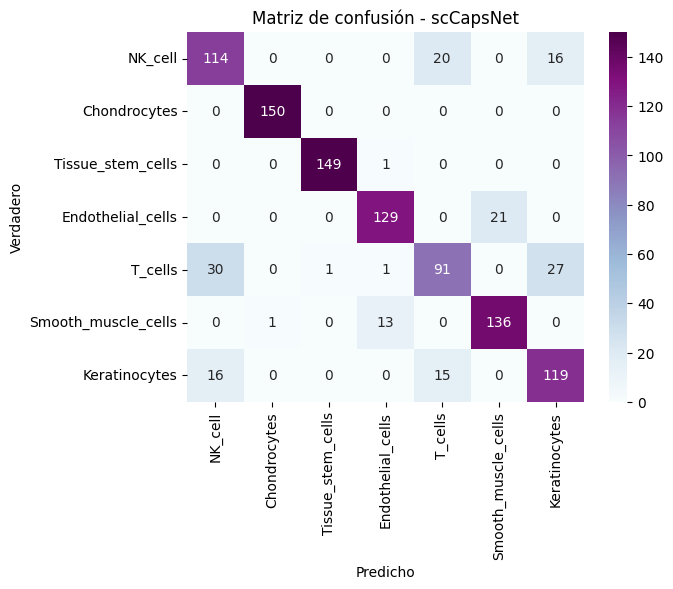

In [ ]:
y_pred_CapsuleNet = CapsuleNetModel.predict(X_test) # Realizamos la predicción
y_pred_CapsuleNet_classes = np.argmax(y_pred_CapsuleNet, axis=1) # Seleccionamos la clase con mayor probabilidad

print("CapsuleNet")
print(classification_report(y_test, y_pred_CapsuleNet_classes, zero_division=0))

cm_CapsuleNet = confusion_matrix(y_test, y_pred_CapsuleNet_classes)
sns.heatmap(cm_CapsuleNet, annot=True, fmt='d', cmap='BuPu',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusión - scCapsNet')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

In [ ]:
CapsuleNetModel.save_weights('Modelweight.weights.h5')

## (5.3) GRU

La red implementada en el código es una Red Neuronal Recurrente (RNN) profunda, que utiliza celdas GRU (Gated Recurrent Unit) para la clasificación multiclase de secuencias. A diferencia de una red densa que procesa todos los datos a la vez, esta arquitectura está diseñada para interpretar el orden y el contexto de los datos, tratando el perfil de expresión de una célula como una secuencia de genes ordenada por su posición cromosómica. En lugar de simplemente reducir la dimensionalidad, el objetivo es capturar las dependencias y patrones a lo largo de esta secuencia.

Respecto a los elementos que conforman la red:

 * Celda GRU (Gated Recurrent Unit): Es la unidad fundamental de la red que reemplaza a una neurona tradicional en una RNN simple. Cada celda GRU procesa un elemento de la secuencia (un gen) a la vez y utiliza dos mecanismos internos llamados compuertas para gestionar un estado de memoria:

    * Compuerta de Reinicio: Decide cuánta información de la memoria pasada es relevante para el cálculo del estado actual.

    * Compuerta de Actualización: Determina qué parte de la memoria pasada se conserva y qué parte de la nueva información se añade, permitiendo que la red "recuerde" patrones a largo plazo.

    ![imagenGRU](https://towardsdatascience.com/wp-content/uploads/2022/02/13a8HnDUlzhhKcSpQzOyiCQ.png)

 * Capa de Dropout: Similar a las redes densas, se implementa una capa de dropout dentro de cada celda GRU. Esto apaga aleatoriamente algunas neuronas durante el entrenamiento para evitar que la red se sobreajuste y memorice la secuencia de entrenamiento.

Continuando, respecto a la arquitectura de la red se tiene:

 * Entrada: Se ingresa un vector de expresión génica de una célula, que ha sido previamente ordenado para formar una secuencia.

 * Extracción de Características Inicial: Antes del procesamiento recurrente, los datos pasan por una capa densa completamente conectada (TimeDistributed(Dense)). Esta capa aplica una pequeña red densa a cada gen de la secuencia de forma independiente, creando una representación más rica y de mayor dimensionalidad para cada punto de la secuencia.

 * Núcleo Recurrente Profundo: La secuencia enriquecida luego pasa a través de una pila de varias capas GRU (gru_layers). La primera capa GRU procesa la secuencia de entrada y produce una nueva secuencia de representaciones. Esta salida se convierte en la entrada para la siguiente capa GRU, permitiendo que el modelo aprenda patrones jerárquicos y cada vez más abstractos de las dependencias genéticas.

 * Vector de Resumen: La última capa GRU (gru_last) recibe la secuencia de la capa anterior pero solo produce un único vector de estado final. Este vector actúa como una codificación o "resumen" de toda la secuencia de genes, capturando la información más relevante de la célula para la clasificación.

 * Salida: Este vector de resumen final se pasa a una capa densa completamente conectada de salida (classifier) que tiene tantas neuronas como número de clases. Esta capa produce las puntuaciones finales (logits) para cada tipo celular. La función de pérdida SparseCategoricalCrossentropy se encarga de convertir estas puntuaciones en probabilidades para determinar la clase más probable.

 ![imagenRED-GRU](https://i.imgur.com/2TcmUxo.jpeg)

In [ ]:
class scDLC_scRNAseqClassifier(Model):
    def __init__(self,
                 num_classes: int,
                 num_steps: int,
                 lstm_size: int = 64,
                 num_layers: int = 2,
                 grad_clip: float = 5.0,
                 dropout_rate: float = 0.7,
                 patience: int = 6,
                 **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.num_steps = num_steps
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.grad_clip = grad_clip
        self.dropout_rate = dropout_rate
        self.patience = patience

        # Input projection
        self.dense_proj = layers.TimeDistributed(
            layers.Dense(units=2 * num_steps, activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l2(0.003))
        )

        # Stacked GRU layers
        self.gru_layers = []
        for _ in range(num_layers):
            self.gru_layers.append(
                layers.GRU(units=lstm_size,
                           return_sequences=True,
                           dropout=1 - dropout_rate)
            )
        # Final GRU to get last output
        self.gru_last = layers.GRU(units=lstm_size, dropout=1 - dropout_rate)

        # Output layer
        self.classifier = layers.Dense(units=num_classes)

    def call(self, inputs, training=False):
        # inputs: [batch, time, features]
        x = tf.expand_dims(inputs, axis=-1)  # ensure shape [batch, time, 1]
        x = self.dense_proj(x, training=training)
        for gru in self.gru_layers:
            x = gru(x, training=training)
        x = self.gru_last(x, training=training)
        logits = self.classifier(x)
        return logits

    def compile_and_fit(self,
                        X_train,
                        y_train,
                        X_val=None,
                        y_val=None,
                        batch_size: int = 11,
                        n_epoch: int = 30,
                        exp_decay: bool = True):
        # Learning rate schedule
        if exp_decay:
            initial_lr = 0.005
            final_lr = 0.001
            total_steps = n_epoch * np.ceil(len(X_train) / batch_size)
            lr_fn = optimizers.schedules.ExponentialDecay(
                initial_lr,
                decay_steps=total_steps,
                decay_rate=final_lr / initial_lr,
                staircase=False)
        else:
            lr_fn = initial_lr = 0.001

        optimizer = optimizers.RMSprop(learning_rate=lr_fn, clipnorm=self.grad_clip)
        self.compile(optimizer=optimizer,
                     loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[metrics.SparseCategoricalAccuracy()])

        # EarlyStopping callback to halt when validation loss stabilizes
        es = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=self.patience,
            restore_best_weights=True
        )

        history = self.fit(
            x=X_train,
            y=y_train,
            validation_data=(X_val, y_val) if X_val is not None else None,
            batch_size=batch_size,
            epochs=n_epoch,
            callbacks=[es]
        )
        return history

    def predict_classes(self, X_test, batch_size: int = 11):
        logits = self.predict(X_test, batch_size=batch_size)
        return np.argmax(logits, axis=1)

    def save_model(self, path: str):
        self.save_weights(path)

    def load_model(self, path: str):
        self.build(input_shape=(None, self.num_steps, 1))
        self.load_weights(path)
        print(f"Model weights loaded from {path}")

In [ ]:
GRU = scDLC_scRNAseqClassifier(
        num_classes=num_classes,
        num_steps=100,
        lstm_size=64,
        num_layers=2,
        dropout_rate=0.7,
        patience=3)

In [ ]:
GRU.summary()

Model: "sc_dlc_sc_rn_aseq_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 500, 200)       │           400 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 500, 64)        │        51,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 500, 64)        │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,695 (795.69 KB)

 Trainable params: 101,847 (397.84 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,848 (397.85 KB)

In [ ]:
GRU_history = GRU.compile_and_fit(
        X_train, y_train,
        X_test, y_test,
        batch_size=16,
        n_epoch=30,
        exp_decay=True
    )

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - loss: 1.5304 - sparse_categorical_accuracy: 0.3800 - val_loss: 1.1483 - val_sparse_categorical_accuracy: 0.5171
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 262s 995ms/step - loss: 1.1021 - sparse_categorical_accuracy: 0.5448 - val_loss: 1.2511 - val_sparse_categorical_accuracy: 0.5305
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 262s 997ms/step - loss: 1.0162 - sparse_categorical_accuracy: 0.5777 - val_loss: 0.8496 - val_sparse_categorical_accuracy: 0.6429
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - loss: 0.8831 - sparse_categorical_accuracy: 0.6305 - val_loss: 0.8241 - val_sparse_categorical_accuracy: 0.6648
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.8216 - sparse_categorical_accuracy: 0.6503 - val_loss: 0.7834 - val_sparse_categorical_accuracy: 0.6695
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - loss: 0.7530 - sparse_categorical_accuracy: 0.6680 - val_loss: 0.8078 - val_sparse_categorical_accuracy:

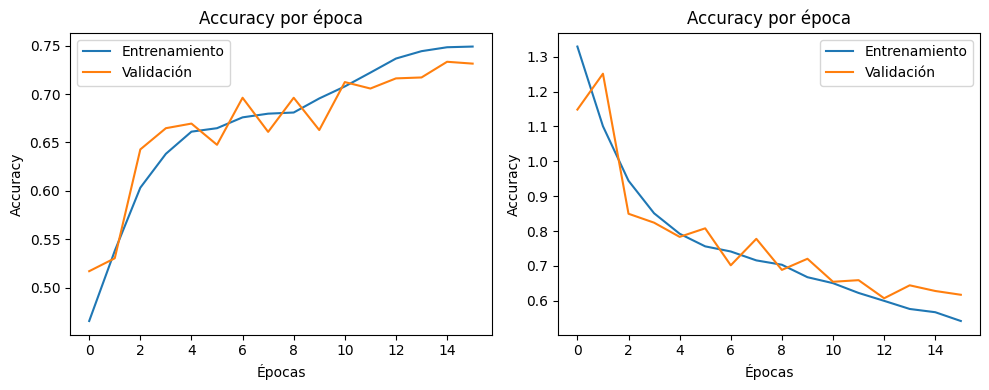

In [ ]:
# Accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(GRU_history.history['sparse_categorical_accuracy'], label='Entrenamiento')
plt.plot(GRU_history.history['val_sparse_categorical_accuracy'], label='Validación')
plt.title('Accuracy por época')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Pérdida
plt.subplot(1,2,2)
plt.plot(GRU_history.history['loss'], label='Entrenamiento')
plt.plot(GRU_history.history['val_loss'], label='Validación')
plt.title('Accuracy por época')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 447ms/step
GRU
              precision    recall  f1-score   support

           0       0.55      0.65      0.60       150
           1       0.97      0.97      0.97       150
           2       0.99      0.94      0.96       150
           3       0.81      0.73      0.77       150
           4       0.39      0.27      0.32       150
           5       0.76      0.85      0.80       150
           6       0.53      0.60      0.56       150

    accuracy                           0.72      1050
   macro avg       0.71      0.72      0.71      1050
weighted avg       0.71      0.72      0.71      1050



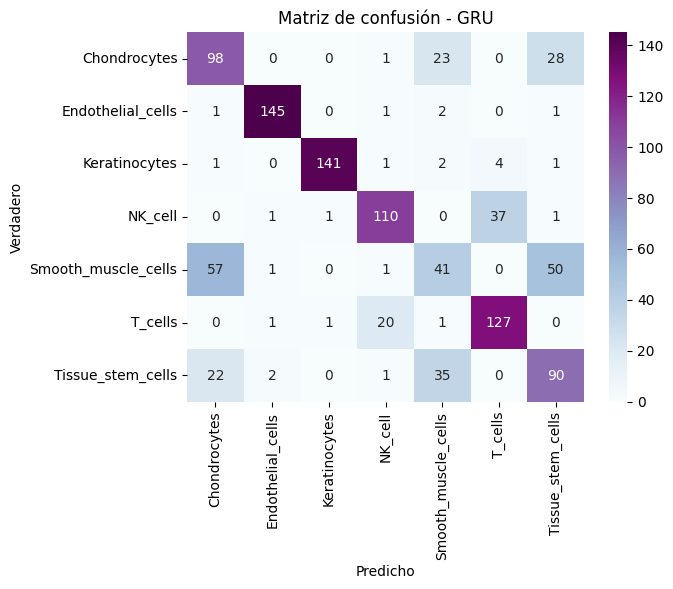

In [ ]:
y_pred_GRU = GRU.predict(X_test) # Realizamos la predicción
y_pred_GRU_classes = np.argmax(y_pred_GRU, axis=1) # Seleccionamos la clase con mayor probabilidad

print("GRU")
print(classification_report(y_test, y_pred_GRU_classes, zero_division=0))

cm_GRU = confusion_matrix(y_test, y_pred_GRU_classes)
sns.heatmap(cm_GRU, annot=True, fmt='d', cmap='BuPu',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusión - GRU')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

# (5) Resultados

A continuación, se realizará una votación para definir la clase predicha. Para esta votación, se utilizan los resultados de los 8 algoritmos de ML entrenados junto con los 3 resultados de las redes neuronales implementadas.

In [ ]:
# Crear un DataFrame con las predicciones de cada modelo
predictions_df = pd.DataFrame({
    'True_Label': le.inverse_transform(y_test),  # etiquetas reales (decodificadas)
    'LogisticRegression': le.inverse_transform(y_pred_lr),
    'RandomForest': le.inverse_transform(y_pred_rf),
    'GradientBoosting': le.inverse_transform(y_pred_gb),
    'AdaBoost': le.inverse_transform(y_pred_ada),
    'XGBoost': le.inverse_transform(y_pred_xgb),
    'LightGBM': le.inverse_transform(y_pred_lgbm),
    'SVM': le.inverse_transform(y_pred_svm),
    'KNN': le.inverse_transform(y_pred_knn),
    'NeuralNetwork': le.inverse_transform(y_pred_nn_classes),
    'CapsuleNet': le.inverse_transform(y_pred_CapsuleNet_classes),
    'GRU': le.inverse_transform(y_pred_GRU_classes)
})

predictions_df.head()

,True_Label,LogisticRegression,RandomForest,GradientBoosting,AdaBoost,XGBoost,LightGBM,SVM,KNN,NeuralNetwork,CapsuleNet,GRU
0,NK_cell,NK_cell,NK_cell,NK_cell,T_cells,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell
1,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell
2,Chondrocytes,Chondrocytes,Chondrocytes,Chondrocytes,Smooth_muscle_cells,Chondrocytes,Chondrocytes,Chondrocytes,Tissue_stem_cells,Chondrocytes,Chondrocytes,Chondrocytes
3,Tissue_stem_cells,Smooth_muscle_cells,Tissue_stem_cells,Tissue_stem_cells,Tissue_stem_cells,Tissue_stem_cells,Tissue_stem_cells,Tissue_stem_cells,Tissue_stem_cells,Tissue_stem_cells,Tissue_stem_cells,Tissue_stem_cells
4,NK_cell,NK_cell,NK_cell,NK_cell,T_cells,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell


Tomamos las predicciones que se encuentran organizadas por columna, excluyendo la etiqueta real y tomamos la moda por fila. De esta manera, la clase con más votos (de mayor moda) es seleccionada como predicción final del modelo.

In [ ]:
# Tomamos solo las columnas de predicción (excluyendo la verdadera)
model_predictions = predictions_df.drop(columns=['True_Label'])

# Aplicamos voto por mayoría fila por fila usando la moda
voting_preds = model_predictions.mode(axis=1)[0]

# Agregamos los resultados de la votación al df de las predicciones.
predictions_df['Voto'] = voting_preds

In [ ]:
predictions_df.head(3)

,True_Label,LogisticRegression,RandomForest,GradientBoosting,AdaBoost,XGBoost,LightGBM,SVM,KNN,NeuralNetwork,CapsuleNet,GRU,Voto
0,NK_cell,NK_cell,NK_cell,NK_cell,T_cells,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell
1,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell,NK_cell
2,Chondrocytes,Chondrocytes,Chondrocytes,Chondrocytes,Smooth_muscle_cells,Chondrocytes,Chondrocytes,Chondrocytes,Tissue_stem_cells,Chondrocytes,Chondrocytes,Chondrocytes,Chondrocytes


Finalmente, calculamos las métricas del ensamble de algoritmos (columna de voto) y graficamos su matriz de confusión.

Ensamble - Votación
Accuracy: 0.8571
                     precision    recall  f1-score   support

       Chondrocytes       0.69      0.79      0.74       150
  Endothelial_cells       0.99      1.00      1.00       150
      Keratinocytes       1.00      1.00      1.00       150
            NK_cell       0.92      0.87      0.89       150
Smooth_muscle_cells       0.75      0.65      0.70       150
            T_cells       0.88      0.92      0.90       150
  Tissue_stem_cells       0.78      0.77      0.77       150

           accuracy                           0.86      1050
          macro avg       0.86      0.86      0.86      1050
       weighted avg       0.86      0.86      0.86      1050



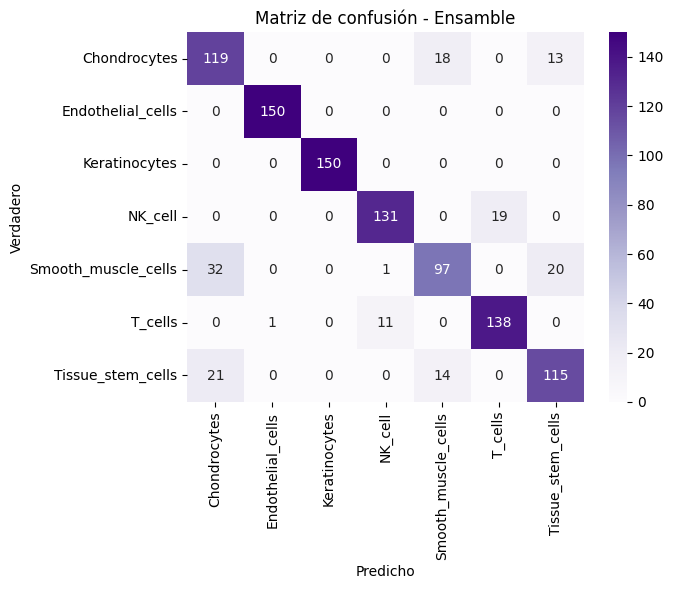

In [ ]:
# Evaluación del ensamble
print("Ensamble - Votación")

# Convertimos Y nuevamente a variable categórica y calculamos las métricas del ensamble.
y_test_labels = le.inverse_transform(y_test)

print(f"Accuracy: {accuracy_score(y_test_labels, voting_preds):.4f}")
print(classification_report(y_test_labels, voting_preds, zero_division=0))

cm_knn = confusion_matrix(y_test_labels, voting_preds)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusión - Ensamble')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

Para facilitar la comparación de los resultados obtenidos, construimos una tabla con los resultados de las métricas de cada modelo entrenado, incluyendo las de la votación. El análisis de estos resultados se encuentra detallado en el artículo

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Lista de nombres de modelos en las columnas del DataFrame
model_names = [
    'LogisticRegression', 'RandomForest', 'GradientBoosting', 'AdaBoost',
    'XGBoost', 'LightGBM', 'SVM', 'KNN', 'NeuralNetwork', 'CapsuleNet', 'GRU', 'Voto'
]

# Crear lista para almacenar las métricas
metrics = []

# Iterar sobre cada modelo
for model in model_names:
    y_true = predictions_df['True_Label']
    y_pred = predictions_df[model]

    # Calcular métricas macro
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Guardar resultados
    metrics.append({
        'Modelo': model,
        'Accuracy': round(accuracy, 4),
        'Precision Macro': round(precision, 4),
        'F1-Score Macro': round(f1, 4)
    })

# Crear DataFrame con los resultados
metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.sort_values(by='F1-Score Macro', ascending=False).reset_index(drop=True)
metrics_df.index += 1

# Mostrar la tabla
print("Métricas por modelo:")
display(metrics_df)

Métricas por modelo:


,Modelo,Accuracy,Precision Macro,F1-Score Macro
1,Voto,0.8571,0.8585,0.8566
2,NeuralNetwork,0.8571,0.8599,0.8556
3,SVM,0.8533,0.8544,0.8524
4,XGBoost,0.8457,0.8468,0.8456
5,GradientBoosting,0.8448,0.8456,0.8448
6,CapsuleNet,0.8457,0.8454,0.8445
7,LightGBM,0.8448,0.8464,0.8445
8,RandomForest,0.8314,0.8316,0.8301
9,LogisticRegression,0.8219,0.8222,0.8220
10,KNN,0.8076,0.8100,0.8071


In [ ]:
predictions_df.to_csv('Predicciones_modelos')

In [ ]:
metrics_df.to_csv('Metricas_modelos')

# Referencias.

* Tarun. D. (2024). AdaBoost Algorithm in Machine Learning. Disponible en: https://datamantra.medium.com/adaboost-algorithm-in-machine-learning-ed40c8d86d60
* Lyu, J., Zheng, P., Qi, Y., & Huang, G. (2023). LightGBM-LncLoc: A LightGBM-Based Computational Predictor for Recognizing Long Non-Coding RNA Subcellular Localization. Mathematics, 11(3), 602. https://doi.org/10.3390/math11030602
* Ramraj, S., Uzir, N., Raman, S., & Banerjee, S. (2016). Experimenting XGBoost algorithm for prediction and classification of different datasets. International Journal of Control Theory and Applications, 9(40).
* Wani, S. A., Quadri, S., Mir, M. S., & Gulzar, Y. (2025). A Comparative Study of Machine Learning Techniques for Cell Annotation of scRNA-Seq Data. Algorithms, 18(4), 232. https://doi.org/10.3390/a18040232